# Listen, Attend and Spell
https://arxiv.org/abs/1508.01211

## Dataset

http://www.openslr.org/12/
Librispeech ASR corpus. Training set clean. 6.3 gigs.

In [1]:
!wget http://www.openslr.org/resources/12/train-clean-100.tar.gz
!tar -C /content/ -xf /content/train-clean-100.tar.gz

--2019-12-21 13:00:12--  http://www.openslr.org/resources/12/train-clean-100.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6387309499 (5.9G) [application/x-gzip]
Saving to: ‘train-clean-100.tar.gz’

train-clean-100.tar 100%[===================>]   5.95G  29.5MB/s    in 3m 33s  

2019-12-21 13:03:46 (28.6 MB/s) - ‘train-clean-100.tar.gz’ saved [6387309499/6387309499]



In [2]:
import os
import random
import datetime
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install torchaudio
import torchaudio
from torchaudio.transforms import MelSpectrogram

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# !pip install torchviz
# from torchviz import make_dot

from torch.utils.tensorboard import SummaryWriter

     |████████████████████████████████| 2.7MB 2.8MB/s 
     |████████████████████████████████| 773.1MB 9.2kB/s 
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 1.3.0 which is incompatible.
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


In [20]:
# pytorch device
DEVICE = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [0]:
!rm /content/train-clean-100.tar.gz

### Dataset Splitting and Analysis



In [0]:
# move all files to one folder, for easy distribution
!mkdir /content/dataset
!for speaker_file in /content/LibriSpeech/train-clean-100/* ; do for chapter_file in "$speaker_file"/*; do for audio in "$chapter_file"/* ; do mv "$audio" /content/dataset; done; done; done;

In [0]:
# !ls /content/dataset/*.flac -1 | wc -l  # audio files
# !ls /content/dataset/*.txt -1 | wc -l   # text files

In [9]:
# read the transcript
dataset_dir = '/content/dataset/'
files = os.listdir(dataset_dir)

data = []
for f in files: 
    if '.txt' in f:
        with open(os.path.join(dataset_dir, f)) as text_file:
            data_list = text_file.readlines()
        for example in data_list:
            id_, sent = str(example.split(' ')[0]), str(' '.join(example.split(' ')[1:])) # -1 to remove '\n'
            data.append((id_, sent))

print('Num examples:', len(data))
data_df = pd.DataFrame(data, columns=['id', 'sent'])
data_df.head()

Num examples: 28539


,id,sent
0,3436-172162-0000,THE ADVENTURE OF THE CART IT BEFELL IN THE MON...
1,3436-172162-0001,AND I WARN YOU THAT THERE BE NONE OF YOU BUT H...
2,3436-172162-0002,AND EVERY KNIGHT SHALL HAVE A SQUIRE AND TWO Y...
3,3436-172162-0003,SO THEY MADE THEM READY AND THESE WERE THE NAM...
4,3436-172162-0004,SIR DODYNAS LE SAUVAGE SIR OZANNA SIR LADYNAS ...


In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data_df, test_size=0.05)
num_training = train_df.shape[0]
num_testing = test_df.shape[0]
print('Num Training Examples:', num_training)
print('Num Testing Examples:', num_testing)

Num Training Examples: 27112
Num Testing Examples: 1427


Sentence : BUT THE POLICE LOOKED ON WHILE ALL THE BANNERS WERE DESTROYED A FEW PACES FROM HEADQUARTERS MORE BANNERS WENT OUT PURPLE WHITE AND GOLD ONES THEY TOO WERE DESTROYED BEFORE THEY REACHED THE WHITE HOUSE

Shape : torch.Size([1, 128, 939])


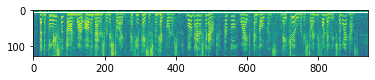

Sample Rate: 16000


In [11]:
idx = random.randint(0, num_training)

clip, sent = train_df.iloc[idx]
clip_path = os.path.join(dataset_dir, clip+'.flac')
print('Sentence :', sent)

spec = MelSpectrogram()    # Draw spectrogram
waveform, sample_rate = torchaudio.load(clip_path)
clip_specgram = spec(waveform)
plt.imshow(clip_specgram[0,:,:].detach().log2())
print('Shape :', clip_specgram.shape)

plt.show()
print("Sample Rate:", sample_rate)
IPython.display.Audio(clip_path)    # play audio

Hence, the sample rate of the audio files is 16Khz.

### HYPERPARAMS

In [12]:
chars = ['<sos>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', "'", '<eos>', '<pad>']

char_to_token = {c:i for i,c in enumerate(chars)} 
token_to_char = {i:c for c,i in char_to_token.items()}
s = "I'AM BUILDING AN ASR SYSTEM"

sos_token = char_to_token['<sos>']
eos_token = char_to_token['<eos>']
pad_token = char_to_token['<pad>']

t = [sos_token] + [char_to_token[c] for c in s.lower()] + [eos_token]
print(t)
print(list(s.lower()))

# pritn tokens
print('<sos>', sos_token)
print('<eos>', eos_token)
print('<pad>', pad_token)

[0, 9, 28, 1, 13, 27, 2, 21, 9, 12, 4, 9, 14, 7, 27, 1, 14, 27, 1, 19, 18, 27, 19, 25, 19, 20, 5, 13, 29]
['i', "'", 'a', 'm', ' ', 'b', 'u', 'i', 'l', 'd', 'i', 'n', 'g', ' ', 'a', 'n', ' ', 'a', 's', 'r', ' ', 's', 'y', 's', 't', 'e', 'm']
<sos> 0
<eos> 29
<pad> 30


### Dataset Class

In [0]:
from torch.utils.data import Dataset, DataLoader

class SpeechDataset(Dataset):
    def __init__(self, df, data_dir):
        """
            df - dataframe from which clips have to be loaded
            data_dir - directory where clips are stored
        """
        self.df = df
        self.data_dir = data_dir
        self.specgram = MelSpectrogram()  # returns spectogram of raw audio
      
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        # preparing audio data
        filename = os.path.join(self.data_dir, self.df['id'].iloc[idx])+'.flac'
        waveform, sample_rate = torchaudio.load(filename)
        x = self.specgram(waveform)

        X = x.log2().clamp(min=-50) # avoid log(0)=-inf
        # Normalize input
        X = (X - X.mean())
        X = X/X.abs().max()

        # preparing target
        sent = self.df['sent'].iloc[idx].lower().replace('\n', '')
        y = torch.tensor([sos_token] + [char_to_token[c] for c in sent] + [eos_token])
        return X, y

tensor([ 0, 20,  8,  1, 20, 27, 20,  8, 18, 15, 21,  7,  8, 27, 20,  8,  5, 13,
        27,  8,  5, 27, 19,  1, 23, 27, 20, 18, 15, 21, 20,  9, 14,  1, 27,  1,
        14,  4, 27, 19, 15, 21, 19, 19,  9, 15, 27,  3, 15, 14, 22,  5, 18, 19,
         9, 14,  7, 27, 20, 15,  7,  5, 20,  8,  5, 18, 27,  8,  5, 27, 19, 20,
        15, 15,  4, 27, 12,  9, 11,  5, 27,  1, 27, 13,  1, 14, 27,  9, 14, 27,
         1, 27,  4, 18,  5,  1, 13, 27, 23,  8,  1, 20, 27,  1, 13, 27,  9, 27,
         2,  5, 20, 18,  1, 25,  5,  4, 27,  8,  1, 19, 27, 20,  8,  9, 19, 27,
         5, 14,  5, 13, 25, 27, 20, 15, 27, 13, 25, 27, 16,  5,  1,  3,  5, 27,
         3,  1, 18, 18,  9,  5,  4, 27,  1, 23,  1, 25, 27, 13, 25, 27,  4,  5,
         1, 18, 27,  6, 12, 15, 18,  9, 14,  1, 29])


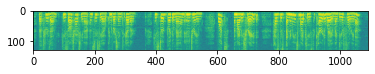

In [12]:
idx = random.randint(0, 10)
trial_dataset = SpeechDataset(train_df, dataset_dir)

x, y = trial_dataset.__getitem__(idx)
plt.imshow(x[0,:,:].detach())
print(y)

### Model

#### Listener

In [0]:
class Listener(nn.Module):
    """
        Multi-layer LSTM with pyramidal structure 
        Performs time down sampling by factor 2 on every layer
    """
    def __init__(self, input_size, hidden_dim, num_layers, dropout=0.0,
                 bidirectional=True, layer_norm=False):
     
        super(Listener, self).__init__()
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Stacking 3 piBLSTM layers, with 512 nodes(i.e. 256 bidirectional)
        self.layers = nn.ModuleList()
        
        input_dim = self.input_size
        for l in range(num_layers):
            self.layers.append(piBLSTM(input_dim, hidden_dim, bidirectional, dropout, layer_norm))
            input_dim = self.layers[-1].out_dim

        self.output_size = self.layers[-1].out_dim
        
    def forward(self, x):
        """
            x - padded sequence of input (batch_size, T, input_size)
        """
        
        for _, layer in enumerate(self.layers):
            x = layer(x)  
        return x

In [0]:
class piBLSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, bidir, dropout, layer_norm):
        super(piBLSTM, self).__init__()
        
        lstm_out_dim = 2*hidden_dim if bidir else hidden_dim
        self.out_dim = 2 * lstm_out_dim  # downsampling in T, upsampling in H
        self.dropout = dropout
        self.layer_norm = layer_norm

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=bidir, 
                         batch_first=True)
        
        # Layer norm : # https://arxiv.org/abs/1607.06450

        if self.layer_norm:
            self.ln = nn.LayerNorm(lstm_out_dim)
        if self.dropout > 0:
            self.dp = nn.Dropout(p=dropout)

    def forward(self, x):
        
        if not self.training:
            self.lstm.flatten_parameters()
        
        out, _ = self.lstm(x)

        if self.layer_norm:
            out = self.ln(out)
        if self.dropout > 0:
            out = self.dp(out)
    
        # ---- Time downsampling --------#

        b, t, h = out.shape
        if t % 2 == 0:
            out = out.reshape(b, int(t/2), int(h*2)).contiguous()
        else:
            out = out[:,:-1,:].reshape(b, int((t-1)/2), -1)  # drop last one from out

        return out

In [65]:
input_size = 128
hidden_dim = 256    # 256 nodes in each LSTM
num_layers = 3
listener = Listener(input_size, hidden_dim, num_layers, dropout=0.1, layer_norm=True)

x = torch.rand((32, 64, 128))    # (N, Tx, H)
out = listener(x)
print('Out.shape', out.shape)

Out.shape torch.Size([32, 8, 1024])


#### Attend and Spell

In [0]:
class Attention(nn.Module):

    def __init__(self, n_h, n_s):
        super(Attention, self).__init__()
        ip_size = n_h + n_s
        self.linear1 = nn.Linear(ip_size, int(ip_size/2))
        self.linear2 = nn.Linear(int(ip_size/2), 1)
        
    def forward(self, h, s_prev):
        """
        Args:
            h -- endoder output (N, Tx, n_h)
            s_prev -- previous hidden state of the Decoder (N, n_s)
        """        
        Tx = h.shape[1] # batch size, N
        s_prev = s_prev.unsqueeze(dim=1).expand(-1, Tx, -1)   # (N, Tx, n_s)
        concat = torch.cat([h, s_prev], dim=2)  

        e = F.relu(self.linear1(concat))    # (N, Tx)
        alphas = F.softmax(self.linear2(e), dim=1)    # sum(alphas) = 1, over Tx axis

        context = torch.bmm(alphas.squeeze(dim=2).unsqueeze(dim=1), h)  # (N, 1, Tx)*(N, Tx, n_h)->(N, 1, n_h)
        return context.squeeze(dim=1)

In [0]:
class AttendAndSpell(nn.Module):
    """ 
        Decodes text from encoded voice
    """

    def __init__(self, embed_dim, hidden_size, encoder_out_size, vocab_size):
        """
            hidden_size: units in LSTM cell
            encoder_out_size: dim of encoder output
            vocab_size: dim of softmax output
                        # In ASR, number of distinct characters 
        """

        super(AttendAndSpell, self).__init__()    
        
        self.n_h = encoder_out_size
        self.hid_sz = hidden_size
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        # Note: shape of c : (N, 1, n_h)
        #       shape of s : (N, 1, hid_sz)
        #       shape of y : (N, 1, embed_dim)

        self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)
        self.attention_layer = Attention(self.n_h, self.hid_sz)
        
        self.pre_lstm_cell = nn.LSTMCell(self.n_h + self.embed_dim, self.hid_sz)
        self.post_lstm_cell = nn.LSTMCell(self.hid_sz + self.n_h, self.hid_sz)

        self.mlp = nn.Sequential(
            nn.Linear(self.hid_sz, vocab_size),
            nn.ReLU(),
            nn.BatchNorm1d(vocab_size),
            nn.Softmax(dim=1)
        )

    def forward(self, yt_prev, hidden_prev, encoder_output, c_prev):
        """
            Decode a single time step
        """
        # ---------------Attend-------------------#
        # s_i = RNN(y_i-1, c_i-1, s_i-1)
        yt_prev = self.embedding(yt_prev)
        rnn_input = torch.cat([yt_prev, c_prev], dim=1)
        h_0, c_0 = self.pre_lstm_cell(rnn_input, hidden_prev[0])
        s_i = h_0

        # context vector: c_i = AttentionContext(encoder_out, s_i)
        context = self.attention_layer(encoder_output, s_i)
        
        #--------------Spell----------------------#
        # concat s_i and c_i and feed to Spell
        spell_input = torch.cat([s_i, context], dim=1)
        h_1, c_1 = self.post_lstm_cell(spell_input, hidden_prev[1])
        out = self.mlp(h_1)
        return out, [(h_0, c_0), (h_1, c_1)], context  

In [18]:
# checking the decoder
encoder_out_size = 6
hid_sz = 10
vocab_size = 5
embed_dim = 8
encoder_out = torch.rand((32, 8, encoder_out_size))  # (N, Tx/8, encoder_out_size)

decoder = AttendAndSpell(embed_dim, hid_sz, encoder_out_size, 5)

y = torch.randint(0, vocab_size, (32,)) # <sos>
hidden_prev = [ ( torch.zeros((32, hid_sz)), torch.zeros((32, hid_sz)) ),
                ( torch.zeros((32, hid_sz)), torch.zeros((32, hid_sz)) ) 
    ]
context = torch.zeros(32, encoder_out_size)

output = []
for i in range(5):
    out, hidden_prev, context = decoder(y, hidden_prev, encoder_out, context)
    print(out.shape)
    output.append(out)

torch.Size([32, 5])
torch.Size([32, 5])
torch.Size([32, 5])
torch.Size([32, 5])
torch.Size([32, 5])


#### Seq2Seq

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, tf_ratio):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.tf_ratio = tf_ratio
        self.loss = nn.CrossEntropyLoss()

    def forward(self, data, target):
        Ty = target.shape[1]
        
        # forward propagte through encoder
        encoder_output = self.encoder(data)
        
        # initialising loss for batch
        loss = 0.0

        N = data.shape[0]   # batch size
        y_in = target[:,0]   # <sos>
        hidden_prev = [ ( torch.zeros((N, self.decoder.hid_sz)).to(DEVICE), 
                          torch.zeros((N, self.decoder.hid_sz)).to(DEVICE)  ),
                       ( torch.zeros((N, self.decoder.hid_sz)).to(DEVICE), 
                          torch.zeros((N, self.decoder.hid_sz)).to(DEVICE)  )
            ]
        context = torch.zeros(N, self.decoder.n_h).to(DEVICE)

        output = []
        for t in range(0, Ty):
            y_true = target[:, t]          
            y_out, hidden_prev, context = self.decoder(y_in, hidden_prev, encoder_output, context)
            output.append(y_out)
            loss += self.loss(y_out, y_true)
            teacher_force = random.random() < self.tf_ratio
            y_in = y_true if teacher_force else y_out.max(dim=1)[1]
        return loss, output

In [21]:
hid_sz = 10
embed_size = 4
vocab_size = 4
ip_size = 40
embed_dim = 10

encoder = Listener(ip_size, 20, 3)
decoder = AttendAndSpell(embed_dim, hid_sz, encoder.output_size, vocab_size)

X = torch.rand((32, 64, ip_size)).to(DEVICE)
Y = torch.randint(0, vocab_size, (32, 10)).to(DEVICE)

s2s = Seq2Seq(encoder, decoder, tf_ratio = 0.0).to(DEVICE)
loss, output = s2s(X, Y)
print(loss)
print(len(output))

tensor(13.9094, device='cuda:0', grad_fn=<AddBackward0>)
10


### Train utils

In [0]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(data):
    """
        overwriting collate_fn method, to pad the
        different length audio present in dataset

        #TODO : Implement BucketIterator, to load
                samples, with same length together
    """
    specgrams = [x.squeeze(0).permute(1, 0) for (x, y) in data]
    targets = [y for (x, y) in data]
    X = pad_sequence(specgrams).permute(1, 0, 2)    # (N, T, H)
    Y = pad_sequence(targets, padding_value=pad_token).permute(1, 0)         # (N, L)
    return X, Y

    # If using ctc loss: sort, pack, pad_packed, returns -> packed, true_lengths
    # X, Y = zip(*sorted(zip(specgrams, targets),     # sort w.r.t to timesteps in spectrogram
    #                     key=lambda x:x[0].shape[2], 
    #                     reverse=True))

In [0]:
def train(model, device, train_loader, optimizer, epoch, print_interval, writer=None, log_interval=-1):
    model.train()
    
    print(f'Training, Logging: Mean loss of previous {print_interval} batches \n')
    
    running_loss = []
    date1 = datetime.datetime.now()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        loss, _ = model(data, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss.append(loss.detach().item()/data.shape[0])    # update running loss
        
        # writing to console after print_interval batches
        if (batch_idx+1) % print_interval == 0:
            date2 = datetime.datetime.now()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tMean Loss : {:.6f}\t time {}:'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                np.mean(running_loss[-print_interval:]), 
                date2 - date1))
            
            date1 = date2

        # Writing to tensorboard
        if (batch_idx+1) % log_interval == 0:
            if writer:
                global_step = epoch * len(train_loader) + batch_idx
                writer.add_scalar('Loss', np.mean(running_loss[-log_interval:]), global_step)

        
# def test(model, device, test_loader, log_interval):
#     model.eval()
#     loss = 0
#     print('-'*10, '\nTesting')
#     date1 = datetime.datetime.now()
#     for batch_idx, (data, target, in_len, tgt_len) in enumerate(test_loader):
#         data, target = data.to(device), target.to(device)
#         in_len, tgt_len = in_len.to(device), tgt_len.to(device)
#         output = model(data)
#         loss += F.ctc_loss(output, target, in_len, tgt_len).detach().item()  # default blank token : 0
#         if batch_idx % log_interval == 0:
#             date2 = datetime.datetime.now()
#             print('Train Epoch: [{}/{} ({:.0f}%)]\t time {}:'.format(
#                 batch_idx * len(data), len(test_loader.dataset),
#                 100. * batch_idx / len(test_loader), date2 - date1))
#             date1 = date2
#     return loss/len(test_loader)

### Training

In [20]:
!mkdir /content/tb_summary
tensorboard_dir = os.path.join('/content', 'tb_summary')

mkdir: cannot create directory ‘/content/tb_summary’: File exists


In [0]:
train_dataset = SpeechDataset(train_df, dataset_dir)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

test_dataset = SpeechDataset(test_df, dataset_dir)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [0]:
input_size = 128    # num rows in instagram
hidden_dim = 64    # 256*2 nodes in each LSTM
num_layers = 3
dropout = 0.1
layer_norm = False   
encoder = Listener(input_size, hidden_dim, num_layers, dropout=dropout, layer_norm=layer_norm)

hid_sz = 64
embed_dim = 15
vocab_size = len(chars)
decoder = AttendAndSpell(embed_dim, hid_sz, encoder.output_size, vocab_size)

model = Seq2Seq(encoder, decoder, tf_ratio = 1.0).to(DEVICE)

In [28]:
# Let's start training
epochs = 10
# optimizer = optim.ASGD(model.parameters(), lr=0.2)  # lr = 0.2 used in paper
optimizer = optim.Adadelta(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.98)
log_interval = 5
print_interval = 40

summary_dir = os.path.join(tensorboard_dir, str(datetime.datetime.now()))
print("summary dir:", summary_dir)
writer = SummaryWriter(summary_dir)

for epoch in range(epochs):
    print("\nTeacher forcing ratio:", model.tf_ratio)
    train(model, DEVICE, train_loader, optimizer, epoch, print_interval, writer, log_interval)
    scheduler.step()                                    # Decrease learning rate
    torch.save(model.state_dict(), f'las_model_small_{epoch}')
    model.tf_ratio = max(model.tf_ratio - 0.01, 0.8)    # Decrease teacher force ratio

summary dir: /content/tb_summary/2019-12-21 08:37:19.682192

Teacher forcing ratio: 1.0
Training, Logging: Mean loss of previous 40 batches 

Train Epoch: 0 [1248/27112 (5%)]	Mean Loss : 29.766352	 time 0:01:05.923958:
Train Epoch: 0 [2528/27112 (9%)]	Mean Loss : 28.545007	 time 0:01:05.186097:
Train Epoch: 0 [3808/27112 (14%)]	Mean Loss : 28.272717	 time 0:01:06.029638:
Train Epoch: 0 [5088/27112 (19%)]	Mean Loss : 27.444069	 time 0:01:05.167296:
Train Epoch: 0 [6368/27112 (23%)]	Mean Loss : 26.617257	 time 0:01:03.717957:
Train Epoch: 0 [7648/27112 (28%)]	Mean Loss : 26.558007	 time 0:01:05.343410:
Train Epoch: 0 [8928/27112 (33%)]	Mean Loss : 26.076940	 time 0:01:05.016955:
Train Epoch: 0 [10208/27112 (38%)]	Mean Loss : 26.219669	 time 0:01:05.725476:
Train Epoch: 0 [11488/27112 (42%)]	Mean Loss : 25.712019	 time 0:01:05.606840:
Train Epoch: 0 [12768/27112 (47%)]	Mean Loss : 25.878213	 time 0:01:05.728761:
Train Epoch: 0 [14048/27112 (52%)]	Mean Loss : 25.320959	 time 0:01:04.878775

#### Tensorboard

In [0]:
#%load_ext tensorboard
#%tensorboard --logdir tb_summary/

### Test

1. Testing on different sentences. With tf_ratio  = 0.9. With batch norm layer (not commented).

In [28]:
model.load_state_dict(torch.load('/content/las_model_small_9'))

<All keys matched successfully>

In [0]:
def decode_pred_sent(out):
    pred_sent = []
    for t in out:
        lol = t.max(dim=1)[1].item()
        pred_sent.append(token_to_char[lol])
    return ''.join(pred_sent)

def decode_true_sent(y):
    sent = []
    for t in y:
        sent.append(token_to_char[t.item()])
    return ''.join(sent)

In [34]:
num_sent = 10
model.eval()
model.tf_ratio = 0.9

for _ in range(num_sent):
    
    idx = random.randint(0, train_df.shape[0])
    trial_dataset = SpeechDataset(train_df, dataset_dir)

    x, y = trial_dataset.__getitem__(idx)
    # plt.imshow(x[0,:,:].detach())

    # Model output
    target = y.unsqueeze(dim=0).to(DEVICE)
    data = x.permute(0, 2, 1).to(DEVICE)
    loss, output = model(data, target)
    print("True sent : ", decode_true_sent(y))
    print("Pred sent : ", decode_pred_sent(output))
    print("Loss :", loss.item())    
    print("\n")

True sent :  <sos>chapter sixteen did teddy know well wouldn't that jar you remarked bluff as he heard what was contained in the brief communication from the lumberman tried to burn down the camp at lumber run did they burst out jerry<eos>
Pred sent :  tuoanter ahn en  aee th  e teeu th l aere  et thet tuneaou weaanded teane an th waard ahit thl ande nn d tn the meond aoneandtetion toom the manber en aheed th teteete n the more an tonber aeneaee the  we e  tnt th  e 
Loss : 666.210205078125


True sent :  <sos>the cars of their friends the french the french moreover were virtual victors their team had finished solidly they had been placed second and third and the driver of the winning german car was reported a belgian<eos>
Pred sent :  rrhe moreean the r wooend  ahe mooeee the mooeee tane wer tere tellirl aeleir  ane m whrr ted aoneth d and ne  ahe  wad ae n tront  aoetnd tnd thend tnd the meene tantthe mongeng toneen aoreaet aealee d thwe oenn 
Loss : 653.517578125


True sent :  <sos

#### Thoughts:

Seeing the above sentences:
1. The model has learned to add spaces.
2. I had tested it after 4 epochs and the output had many 't's, but
now they are comparitively lesser in number.
3. It has also learned common words such as 'the'.

If scaled up, it can give good results, with the same architecture, and
a bigger model.

Possible immprovements in architecture:
1. Implement beam search.
2. Implement bidirectional layers.
